In [1]:
import ipywidgets as widgets
IPython.display.display(HTML('''<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-success" title="Run stage" onclick="runStage(Jupyter.notebook.get_cell_elements().index(this.closest('.cell')));"><i class="fa fa-play"></i>Run stage</button>'''))

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd

## Загружаем исходные данные

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

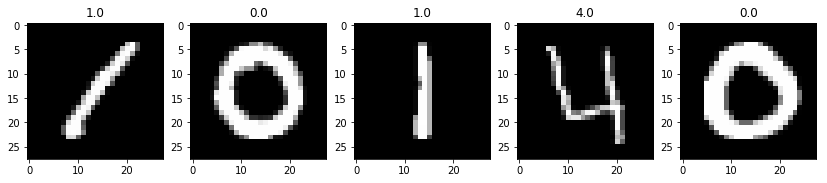

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

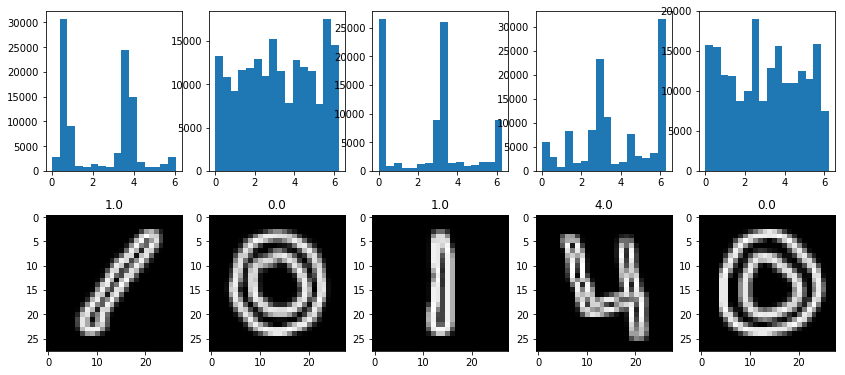

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i-1]);
    subplot = fig.add_subplot(3, 7, i)
#     plt.scatter(np.arange(16), train_hist[i+8-1])
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [67]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [68]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Тут я повернул гистограмму, но это отрицательно сказалось на результате. 
Причем "% 8" поворачивает максимум на Пи, то есть не "переворачивает" девятки и шестерки. 
Пробовал убирать % 8, но это не помогает.
В чем была тайна "правильного" поворота?

In [69]:
# for i in range(len(test_hist)):
#     d = deque(test_hist[i])
#     d.rotate(-(test_hist[i].argmax() % 8))
#     test_hist[i] = list(d)
# for i in range(len(train_hist)):
#     d = deque(train_hist[i])
#     d.rotate(-(train_hist[i].argmax() % 8))
#     train_hist[i] = list(d)

## Нормируем вектор гистограммы

In [70]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [71]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Делаем PCA - фичи

In [72]:
X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [73]:
X_mean = X_train.mean(axis=0)

X_train -= X_mean
X_test -= X_mean

In [74]:
cov = np.dot(X_train.T, X_train) / X_train.shape[0]

In [75]:
U, S, _ = np.linalg.svd(cov)

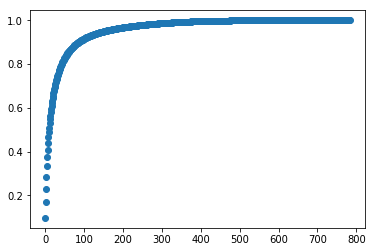

In [76]:
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [104]:
S_thr = 0.8  
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

In [78]:
X_train_reduced = np.dot(X_train, U[:, :n_comp])

In [79]:
X_test_reduced = np.dot(X_test, U[:, :n_comp])

## Сшиваем фичи из  гистограмм и PCA, нормируем

In [81]:
X_train = []
for i in range(len(X_train_reduced)):
    X_train.append(np.concatenate((X_train_reduced[i], train_hist[i])))
X_test = []
for i in range(len(X_test_reduced)):
    X_test.append(np.concatenate((X_test_reduced[i], test_hist[i])))

In [82]:
X_tr = pd.DataFrame.from_records(X_train)
X_te = pd.DataFrame.from_records(X_test)

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
s = StandardScaler()

In [85]:
s.fit(X_tr)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [86]:
X_tr = s.transform(X_tr)
X_te = s.transform(X_te)

In [87]:
X_tr  = pd.DataFrame(X_tr)
X_te = pd.DataFrame(X_te)

## Разбиваем выборку на обучение и валидацию

In [88]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, X_tr, test_size=0.2,
    random_state=42)

## Используем случайный лес

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
clf = RandomForestClassifier()

In [91]:
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
pred_val = clf.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [93]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.919404761904762


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96       816
        1.0       0.98      0.99      0.98       909
        2.0       0.86      0.93      0.89       846
        3.0       0.91      0.89      0.90       937
        4.0       0.92      0.92      0.92       839
        5.0       0.89      0.91      0.90       702
        6.0       0.95      0.94      0.94       785
        7.0       0.94      0.91      0.92       893
        8.0       0.91      0.87      0.89       835
        9.0       0.91      0.86      0.89       838

avg / total       0.92      0.92      0.92      8400



In [95]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[797   1   3   0   3   1   6   1   3   1]
 [  3 898   2   0   1   0   3   0   1   1]
 [  8   2 791  14   0   3   7   4  16   1]
 [  6   1  37 831   0  25   1   5  26   5]
 [  2   3   9   0 772   3   9   7   3  31]
 [  3   0  19  25   2 636   8   0   7   2]
 [ 10   4   9   1   6  12 737   0   4   2]
 [  4   3  25   6  14   5   0 809   7  20]
 [ 10   4  18  27   6  25   4   4 729   8]
 [  9   4  12  13  38   3   1  27   8 723]]


## Обучаемся на всей выборке и предсказываем значения

In [96]:
clf.fit(X_tr, train_label)
pred_test = clf.predict(X_te)

## Визуализируем предсказания

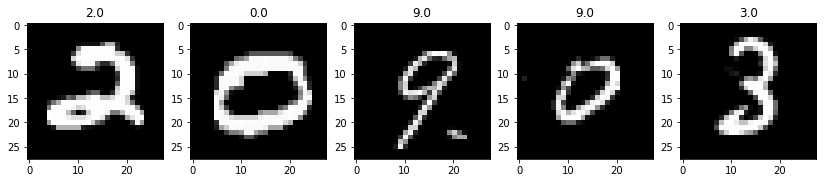

In [97]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [98]:
submit = pd.read_csv('sample_submission.csv')

In [99]:
submit.Label = pred_test

In [100]:
pred_test = [ int(x) for x in pred_test ]


In [101]:
submit.head()

,ImageId,Label
0,1,2.0
1,2,0.0
2,3,9.0
3,4,9.0
4,5,3.0


In [102]:
submit = submit.set_index('ImageId')

In [103]:
submit.to_csv('submission.csv')

Your submission scored 0.90500